# ASTRA Workbench

In [1]:
import astra
import matplotlib.pyplot as plt
import numpy as np
import sys 
sys.path.append('../')
import amglib.readers as rd
import amglib.imageutils as amg
import amglib.widgets as aw

from scipy.ndimage import shift


import importlib

In [2]:
importlib.reload(rd)
importlib.reload(aw)

<module 'amglib.widgets' from 'C:\\Users\\kaestner\\git\\scripts\\python\\notebooks\\..\\amglib\\widgets.py'>

## Check ASTRA

In [3]:
astra.test()

ASTRA Toolbox v2.3.1
Getting GPU info... GPU #0: Quadro RTX 4000, with 8191MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


## Load and prepare data

In [4]:
projselect = aw.FileSelector()
projselect.display()

FileChooser(path='C:\Users\kaestner\git\scripts\python\notebooks', filename='', title='', show_hidden=False, s…

In [5]:
proj = rd.read_images(projselect.file_mask,first=projselect.first_index, last=projselect.last_index)

  0%|          | 0/626 [00:00<?, ?it/s]

In [6]:
obselect = aw.FileSelector()
obselect.display()

FileChooser(path='C:\Users\kaestner\git\scripts\python\notebooks', filename='', title='', show_hidden=False, s…

In [7]:
ob = rd.read_images(obselect.file_mask,first=obselect.first_index, last=obselect.last_index).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
dcselect = aw.FileSelector()
dcselect.display()

FileChooser(path='C:\Users\kaestner\git\scripts\python\notebooks', filename='', title='', show_hidden=False, s…

In [9]:
dc = rd.read_images(dcselect.file_mask,first=dcselect.first_index, last=dcselect.last_index).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

### Normalize

In [10]:
ob.shape

(897, 604)

In [11]:
p = amg.normalizeImage(img=proj,ob=ob,dc=dc,neglog=True)

100%|███████████████████████████████████████████████████████████████████████████████| 626/626 [00:02<00:00, 248.92it/s]


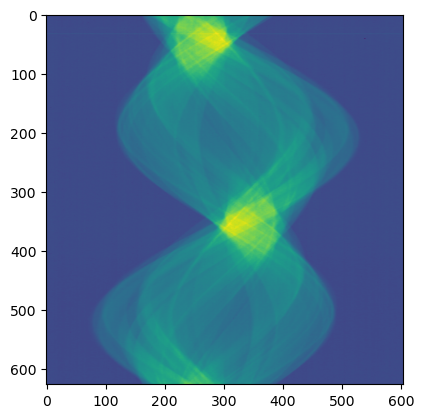

In [13]:
orig_sino = p[:,p.shape[1]//2,:]
plt.imshow(orig_sino)

## The reconstruction

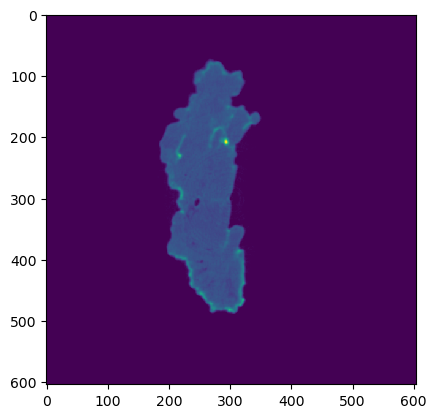

NameError: name 'V_exact_id' is not defined

In [15]:
dx = -2.75
sino = shift(orig_sino,shift={0,dx}, order=3)
# create geometries and projector
N = sino.shape[1]
Np = sino.shape[0]
arc = 2*np.pi
rot = 75

proj_geom = astra.create_proj_geom('parallel', 1.0, N, np.linspace(0, arc, Np, endpoint=False)+rot)

vol_geom = astra.create_vol_geom(N,N)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

sinogram_id = astra.data2d.create('-sino', proj_geom, data=sino)
# reconstruct
recon_id = astra.data2d.create('-vol', vol_geom, 0)

cfg                         = astra.astra_dict('SIRT_CUDA')
cfg['ProjectorId']          = proj_id
cfg['ProjectionDataId']     = sinogram_id
cfg['ReconstructionDataId'] = recon_id
cfg['option']               = { 'MinConstraint': 0, 'MaxConstraint': 1 }

sirt_id = astra.algorithm.create(cfg)

astra.algorithm.run(sirt_id, 300)
V = astra.data2d.get(recon_id)

# plt.imshow(V[100:300,100:300],interpolation="none",cmap='viridis')
plt.imshow(V,interpolation="none",cmap='viridis')
plt.show()

# garbage disposal
astra.data2d.delete([sinogram_id, recon_id, V_exact_id])
astra.projector.delete(proj_id)
astra.algorithm.delete(sirt_id)

In [ ]:
plt.imshow(sinogram)

# Playground

In [ ]:
import re
def find_first_last_indices(filenames):
    indices = []
    
    ext = filenames[0].split('.')[-1]

    pattern=r'_(0*\d+)(\.'+ext+')$'

    for filename in filenames:
        filename = filename.split('/')[-1]
        match=re.search(pattern, filename)
        if match:
            indices.append(int(match.group(1)))  # Convert to integer

    if indices:
        return min(indices), max(indices)
    else:
        return None, None  # If no matches found

In [ ]:
flist=rd.list_matching_files('D:/Kaestner/TestData/Parallel_WoodData/projections/','wood_*.tif')

In [ ]:
find_first_last_indices(flist)

In [ ]:
import os
os.path.basename('D:\\Kaestner\\TestData\\Parallel_WoodData\\projections\\dc_0002.tif')